# GAN Toy example**


In [19]:
import numpy as np
import matplotlib.pyplot as plt

In [20]:
# Get a batch of real data.  Our goal is to make data that looks like this.
def get_real_data_batch(n_sample):
  np.random.seed(0)
  x_true = np.random.normal(size=(1,n_sample)) + 7.5
  return x_true

Define our generator.  This takes a standard normally-distributed latent variable $z$ and adds a scalar $\theta$ to this, where $\theta$ is the single parameter of this generative model according to:

\begin{equation}
x_i = z_i + \theta.
\end{equation}

Obviously this model can generate the family of Gaussian distributions with unit variance, but different means.

In [21]:
# This is our generator -- takes the single parameter theta
# of the generative model and generates n samples
def generator(z, theta):
    x_gen = z + theta
    return x_gen

Now, we define our discriminator.  This is a simple logistic regression model (1D linear model passed through sigmoid) that returns the probability that the data is real

In [22]:
# Define our discriminative model

# Logistic sigmoid, maps from [-infty,infty] to [0,1]
def sig(data_in):
  return  1.0 / (1.0+np.exp(-data_in))

# Discriminator computes y
def discriminator(x, phi0, phi1):
  return sig(phi0 + phi1 * x)

In [23]:
# Draws a figure like Figure 15.1a
def draw_data_model(x_real, x_syn, phi0=None, phi1=None):
  fix, ax = plt.subplots()

  for x in x_syn:
    ax.plot([x,x],[0,0.33],color='#f47a60')
  for x in x_real:
    ax.plot([x,x],[0,0.33],color='#7fe7dc')

  if phi0 is not None:
    x_model = np.arange(0,10,0.01)
    y_model = discriminator(x_model, phi0, phi1)
    ax.plot(x_model, y_model,color='#dddddd')
  ax.set_xlim([0,10])
  ax.set_ylim([0,1])


  plt.show()

Real data: [[9.26405235 7.90015721 8.47873798 9.7408932  9.36755799 6.52272212
  8.45008842 7.34864279 7.39678115 7.9105985 ]]
Latent variable: [[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763 -2.3015387
   1.74481176 -0.7612069   0.3190391  -0.24937038]]
Fake data: [[4.62434536 2.38824359 2.47182825 1.92703138 3.86540763 0.6984613
  4.74481176 2.2387931  3.3190391  2.75062962]]


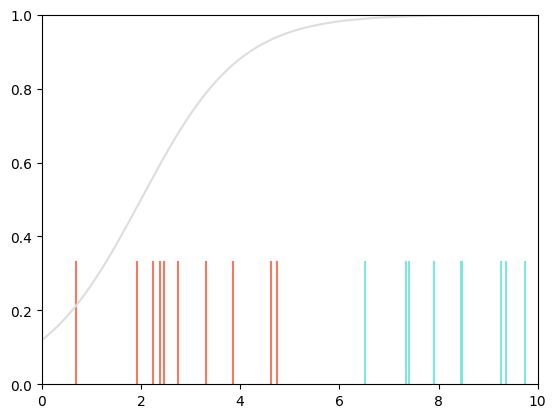

In [24]:
# Get data batch
x_real = get_real_data_batch(10)
print (f'Real data: {x_real}')

# Initialize generator and synthesize a batch of examples
theta = 3.0
np.random.seed(1)
z = np.random.normal(size=(1,10))
x_syn = generator(z, theta)
print (f'Latent variable: {z}')
print (f'Fake data: {x_syn}')

# Initialize discriminator model
phi0 = -2
phi1 = 1

draw_data_model(x_real, x_syn, phi0, phi1)

You can see that the synthesized (orange) samples don't look much like the real (cyan) ones, and the initial model to discriminate them (gray line represents probability of being real) is pretty bad as well.

Let's deal with the discriminator first.  Let's define the loss

In [25]:
# TODO -- compute the loss for the discriminator
def compute_discriminator_loss(x_real, x_syn, phi0, phi1):
    y_real = discriminator(x_real, phi0, phi1)
    y_syn = discriminator(x_syn, phi0, phi1)

    # Real targets = 1 → -log(p), Fake targets = 0 → -log(1 - p)
    loss_real = -np.mean(np.log(y_real + 1e-10))
    loss_syn = -np.mean(np.log(1 - y_syn + 1e-10))

    return loss_real + loss_syn


In [26]:
# Test the loss
loss = compute_discriminator_loss(x_real, x_syn, phi0, phi1)
print("True Loss = 1.3814757170851447, Your loss=", loss )

True Loss = 1.3814757170851447, Your loss= 1.3814757164126126


In [27]:
# Gradient of loss (cheating, using finite differences)
def compute_discriminator_gradient(x_real, x_syn, phi0, phi1):
  delta = 0.0001
  loss1 = compute_discriminator_loss(x_real, x_syn, phi0, phi1)
  loss2 = compute_discriminator_loss(x_real, x_syn, phi0+delta, phi1)
  loss3 = compute_discriminator_loss(x_real, x_syn, phi0, phi1+delta)
  dl_dphi0 = (loss2-loss1) / delta
  dl_dphi1 = (loss3-loss1) / delta

  return dl_dphi0, dl_dphi1

# This routine performs gradient descent with the discriminator
def update_discriminator(x_real, x_syn, n_iter, phi0, phi1):

  # Define learning rate
  alpha = 0.01

  # Get derivatives
  print("Initial discriminator loss = ", compute_discriminator_loss(x_real, x_syn, phi0, phi1))
  for iter in range(n_iter):
    # Get gradient
    dl_dphi0, dl_dphi1 = compute_discriminator_gradient(x_real, x_syn, phi0, phi1)
    # Take a gradient step downhill
    phi0 = phi0 - alpha * dl_dphi0
    phi1 = phi1 - alpha * dl_dphi1

  print("Final Discriminator Loss= ", compute_discriminator_loss(x_real, x_syn, phi0, phi1))

  return phi0, phi1

Initial parameters (phi0,phi1) -2 1
Initial discriminator loss =  1.3814757164126126
Final Discriminator Loss=  0.5595152281671014
Final parameters (phi0,phi1) -2.285238806922583 0.5068593806142876


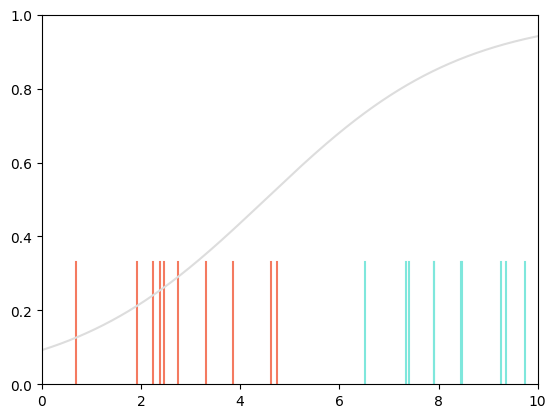

In [28]:
# Let's update the discriminator (sigmoid curve)
n_iter = 100
print("Initial parameters (phi0,phi1)", phi0, phi1)
phi0, phi1 = update_discriminator(x_real, x_syn, n_iter, phi0, phi1)
print("Final parameters (phi0,phi1)", phi0, phi1)
draw_data_model(x_real, x_syn, phi0, phi1)

Now let's update the generator

In [29]:
# TODO -- Run the generator on the latent variables z with the parameters theta
def compute_generator_loss(z, theta, phi0, phi1):
    x_gen = generator(z, theta)
    y_gen = discriminator(x_gen, phi0, phi1)

    # Original GAN loss: minimize log(1 - D(G(z)))
    loss = -np.mean(np.log(1 - y_gen + 1e-10))
    return loss




In [30]:
# Test generator loss to check you have it correct
loss = compute_generator_loss(z, theta, -2, 1)
print("True Loss = 1.378437035945412, Your loss=", loss )

True Loss = 1.378437035945412, Your loss= 1.3784370353731847


In [31]:
def compute_generator_gradient(z, theta, phi0, phi1):
  delta = 0.0001
  loss1 = compute_generator_loss(z,theta, phi0, phi1)
  loss2 = compute_generator_loss(z,theta+delta, phi0, phi1)
  dl_dtheta = (loss2-loss1)/ delta
  return dl_dtheta

def update_generator(z, theta, n_iter, phi0, phi1):
    # Define learning rate
    alpha = 0.02

    # Get derivatives
    print("Initial generator loss = ", compute_generator_loss(z, theta, phi0, phi1))
    for iter in range(n_iter):
      # Get gradient
      dl_dtheta = compute_generator_gradient(x_real, x_syn, phi0, phi1)
      # Take a gradient step (uphill, since we are trying to make synthesized data less well classified by discriminator)
      theta = theta + alpha * dl_dtheta

    print("Final generator loss = ", compute_generator_loss(z, theta, phi0, phi1))
    return theta


Theta before 3.0
Initial generator loss =  0.4049153493251033
Final generator loss =  0.42079911019411387
Theta after 3.0962820568304323


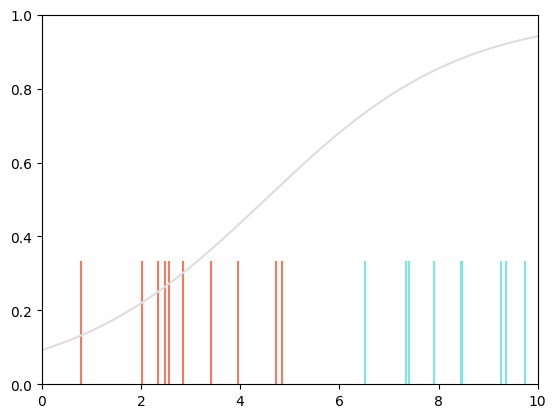

In [32]:
n_iter = 10
theta = 3.0
print("Theta before", theta)
theta = update_generator(z, theta, n_iter, phi0, phi1)
print("Theta after", theta)

x_syn = generator(z,theta)
draw_data_model(x_real, x_syn, phi0, phi1)

Final parameters (phi0,phi1) -2 1


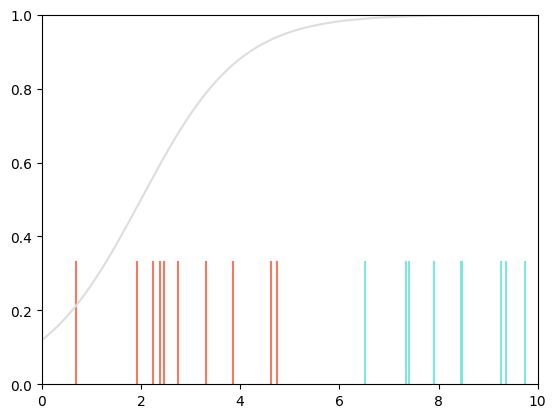

Updating discriminator
Initial discriminator loss =  1.3814757164126126
Final Discriminator Loss=  0.5012274843111082


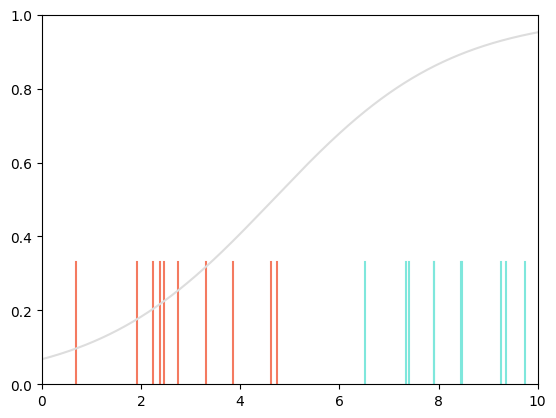

Updating generator
Initial generator loss =  0.3589711592105422
Final generator loss =  0.3642292416529854


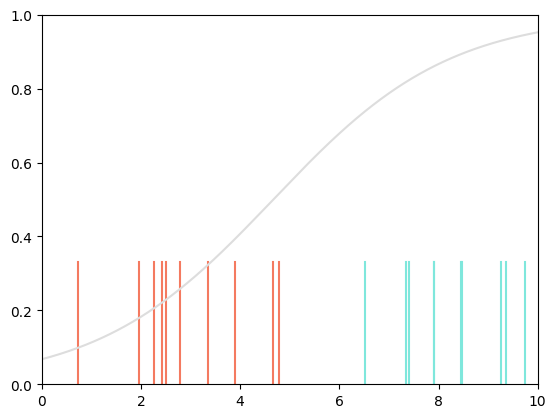

Updating discriminator
Initial discriminator loss =  0.5064855667535514
Final Discriminator Loss=  0.44076180315109154


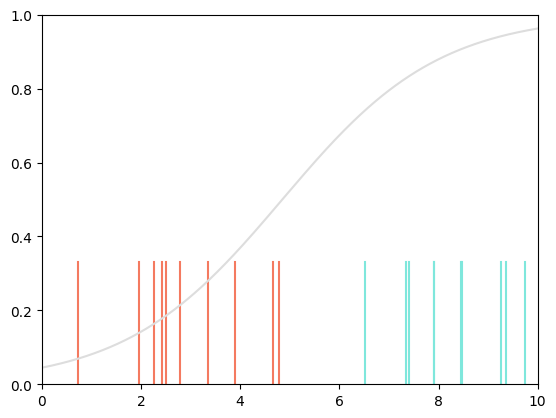

Updating generator
Initial generator loss =  0.3109718602530146
Final generator loss =  0.31686685041417384


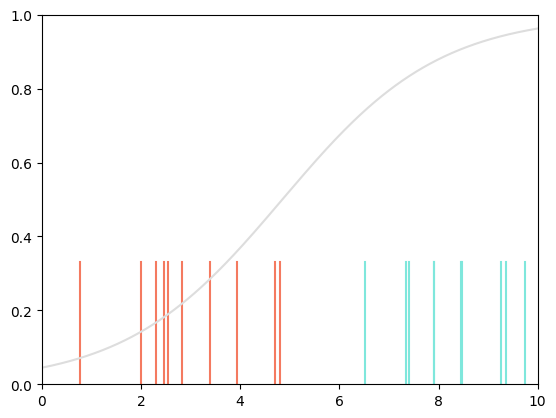

Updating discriminator
Initial discriminator loss =  0.4466567933122508
Final Discriminator Loss=  0.39781599306152604


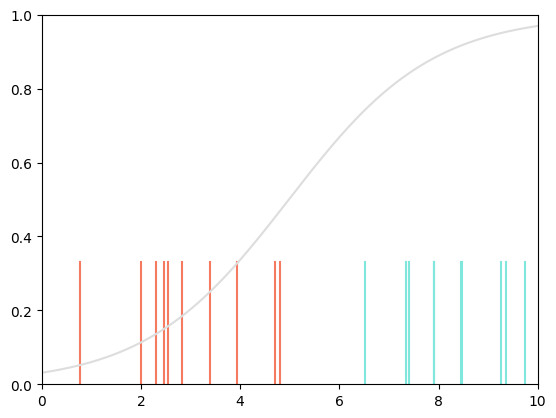

Updating generator
Initial generator loss =  0.27705654341084573
Final generator loss =  0.28345092427910246


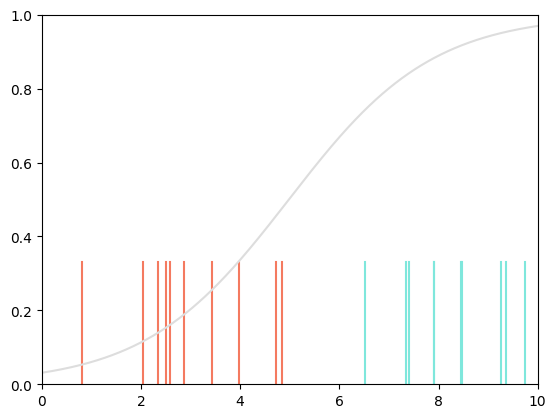

Updating discriminator
Initial discriminator loss =  0.40421037392978276
Final Discriminator Loss=  0.366264487631894


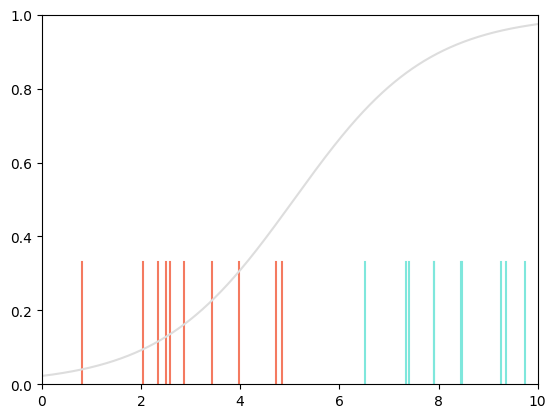

Updating generator
Initial generator loss =  0.2521579782290971
Final generator loss =  0.2589649884290292


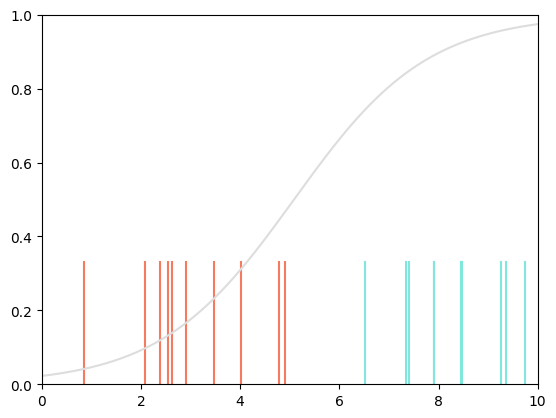

Updating discriminator
Initial discriminator loss =  0.37307149783182614
Final Discriminator Loss=  0.34253611134994255


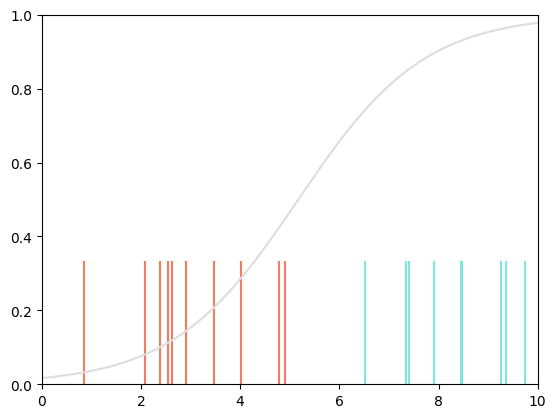

Updating generator
Initial generator loss =  0.23336498929641625
Final generator loss =  0.2405299119991513


In [33]:
# Now let's define a full GAN loop

# Initialize the parameters
theta = 3
phi0 = -2
phi1 = 1

# Number of iterations for updating generator and discriminator
n_iter_discrim = 300
n_iter_gen = 3

print("Final parameters (phi0,phi1)", phi0, phi1)
for c_gan_iter in range(5):

  # Run generator to product synthesized data
  x_syn = generator(z, theta)
  draw_data_model(x_real, x_syn, phi0, phi1)

  # Update the discriminator
  print("Updating discriminator")
  phi0, phi1 = update_discriminator(x_real, x_syn, n_iter_discrim, phi0, phi1)
  draw_data_model(x_real, x_syn, phi0, phi1)

  # Update the generator
  print("Updating generator")
  theta = update_generator(z, theta, n_iter_gen, phi0, phi1)
